In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Global Sensitivity Analysis

We will be performing Sobol Sensitivity Analysis on the model to determine the importance of each input parameter on the output. The Sobol Sensitivity Analysis is a variance-based method that decomposes the variance of the output into contributions from each input parameter and interactions between input parameters. Say we have a function

$$
f:[0, 1]^d \to \mathbb{R}
$$

Where we have the relationship:

$$
x = (x_1, x_2, \ldots, x_d) \to y = f(x_1, x_2, \ldots, x_d)
$$

And we will define the Sobol indices as:

$$
S_i = \frac{\mathbb{V_i}}{\mathbb{V}}
$$


## Duffing Oscillator

To demonstrate will again work with the Duffing Oscillator. As a reminder it is given by the following equation:

$$
\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t)
$$

Written down as a vector field, we have:

$$
\begin{align*}
\dot{x} &= v \\
\dot{v} &= -\delta v - \alpha x - \beta x^3 + \gamma \cos(\omega t)
\end{align*}
$$

Using the same code as before:

In [29]:
import numpy as np
import jax
from jax import grad, vmap, jit
import jax.numpy as jnp
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt
# This library is will be used to perform the Sobol sensitivity analysis.
import SALib.sample.sobol as sobol
import SALib.analyze.sobol as analyze_sobol


def vector_field(t, y, theta):
    alpha, beta, gamma, delta, omega = theta[:5]
    x = y[0]
    v = y[1]
    return jnp.array(
        [
            v,
            - alpha * x - beta * x ** 3 - delta * v + gamma * jnp.cos(omega * t)
        ]
    )
theta = jnp.array([
    1.0,  # alpha
    5.0,  # beta
    0.37, # gamma
    0.1,  # delta
    1.0,  # omega
])
# The numerical solver to use.
solver = Tsit5()
# At which timesteps to store the solution.
saveat = SaveAt(ts=jnp.linspace(0, 50, 1000))
# The differential equation term.
term = ODETerm(vector_field)
# The Solution for one theta.
sol = diffeqsolve(
    term,
    solver,
    t0=0,                       # Initial time
    t1=50,                      # Terminal time
    dt0=0.1,                    # Initial timestep - it will be adjusted
    y0=jnp.array([0.0, 0.0]),   # Initial value
    args=theta,
    saveat=saveat
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


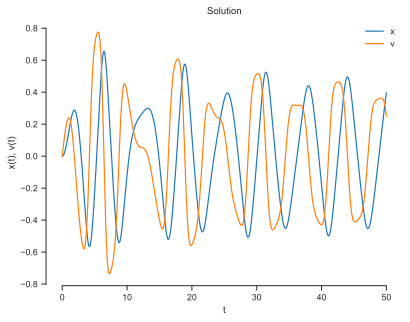

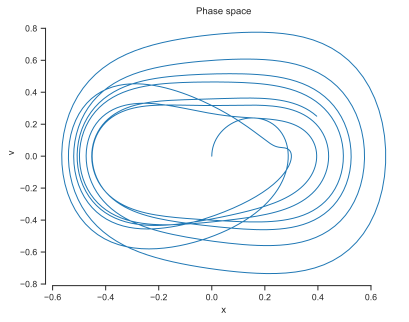

In [30]:
# Lets plot it againt to remind ourselves of the solution.
fig, ax = plt.subplots()
ax.plot(sol.ts, sol.ys[:, 0], label="x")
ax.plot(sol.ts, sol.ys[:, 1], label="v")
ax.set(xlabel="t", ylabel="x(t), v(t)")
ax.title.set_text("Solution")
ax.legend(frameon=False)
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.plot(sol.ys[:, 0], sol.ys[:, 1], lw=1)
ax.set(xlabel="x", ylabel="v")
ax.title.set_text("Phase space")
sns.despine(trim=True);

I will walk you through SALib's implementation of the Sobol Sensitivity Analysis.
First we must define how much to vary the parameters. Then this will be placed with the parameters into a dictionary.

In [31]:
# This time we will set do Global Sensitivity Analysis, lets set up the problem.
# First we need to define how much to vary the inputs. 
perturbation = 0.01 # % perturbation

# Make the bounds +/- perturbation with the same center as the original theta.
bounds = jnp.array([
    theta - perturbation * theta,
    theta + perturbation * theta
    ])

# Problem definition for the Sobol sensitivity analysis.
problem = {
    'num_vars': len(theta),
    'names': ['alpha', 'beta', 'gamma', 'delta', 'omega'],
    'bounds': bounds.T.tolist()
}

Now we will use sample the parameter space using the Sobol sampler. This will generate a matrix of parameter values. We will then run the model for each row of the matrix and store the output.

We are mostly interested in the first order indices, which tell us how much the variance of the output is due to the variance of each input parameter. The total indices tell us how much the variance of the output is due to the variance of each input parameter and interactions with other input parameters.

In [32]:
# The number of samples to generate (should be a power of 2).
N = 512
# Generate the samples.
param_values = sobol.sample(problem, N, calc_second_order=False)
print(param_values.shape)

(3584, 5)


Notice the strange shape of the samples array. The number of columns matches our number of variables and the rows correspond to the number of samples. The sobol sampler generates the number of samples as $N \times (D + 2)$ row where $N$ is the input of samples and $D$ is the number of parameters if second order indices are not calculated. Or $N \times (2D + 2)$ if we include the second order indices. Let us now define the functions to run the model and then we will run the Sobol Sensitivity Analysis.

In [33]:
# Define a function that runs the model for a single parameter set
def run_model(p):
    sol = diffeqsolve(
        term,
        solver,
        t0=0,
        t1=50,
        dt0=0.1,
        y0=jnp.array([0.0, 0.0]),
        args=p,
        saveat=saveat
    )
    return sol.ys

# Run the model for all parameter sets
Y = vmap(run_model)(param_values)

# Split into Results for each state
Y_x, Y_v = Y[:, :, 0], Y[:, :, 1]

First we will calculate just the first order indices

In [34]:
# Extract the times from the calculated solution
times = sol.ts
num_timesteps = len(times)

# Define a function that runs the Sobol analysis for a single timestep
def analyze_firstIndices(t):
    # Sobol analysis for x(t)
    Si_x = analyze_sobol.analyze(
        problem,
        Y_x[:, t],
        calc_second_order=False,
        print_to_console=False
    )
    # Sobol analysis for v(t)
    Si_v = analyze_sobol.analyze(
        problem,
        Y_v[:, t],
        calc_second_order=False,
        print_to_console=False
    )
    return (Si_x['S1'], Si_v['S1'])  # Return first-order indices for x and v

# Run the analysis for all timesteps (Cannot be vmapped because of the SALib API)
results = [analyze_firstIndices(t) for t in range(num_timesteps)]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Let's take a look at these first order indices and how the evolve over time.

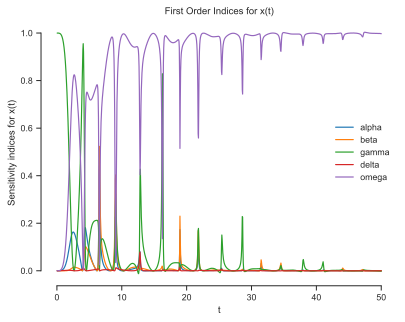

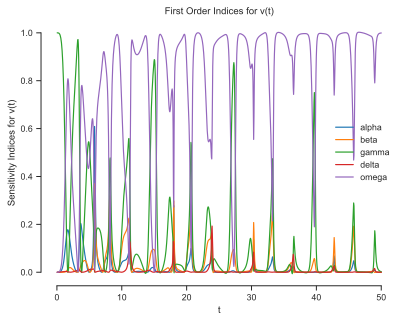

In [35]:
# Unzip the results and split into x and v
S_x, S_v = zip(*results)
S_x, S_v = np.array(S_x), np.array(S_v)

# Plot with indices of x(t) with a for loop
fig, ax = plt.subplots()
for i, name in enumerate(problem['names']):
    ax.plot(times, S_x[:, i], label=name)
ax.set(xlabel="t", ylabel="Sensitivity indices for x(t)")
ax.title.set_text("First Order Indices for x(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

# Plot with indices of v(t) with a for loop
fig, ax = plt.subplots()
for i, name in enumerate(problem['names']):
    ax.plot(times, S_v[:, i], label=name)
ax.set(xlabel="t", ylabel="Sensitivity Indices for v(t)")
ax.legend(frameon=False)
ax.title.set_text("First Order Indices for v(t)")
sns.despine(trim=True);

Viewing the above plots, we can see that initially the oscillator is very sensitive to changes in $\gamma$ but then becomes very dominated by perturbations in $\omega$ as the systems evolves.

These Sobol indices should always sum to 1. Lets plot the cumulative sum of the first order indices over time to see if this is the case.

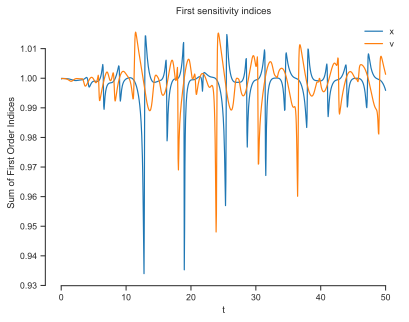

In [36]:
# Plot the total sensitivity indices
fig, ax = plt.subplots()
ax.plot(times, np.sum(S_x, axis=1), label="x")
ax.plot(times, np.sum(S_v, axis=1), label="v")
ax.set(xlabel="t", ylabel="Sum of First Order Indices")
ax.legend(frameon=False)
ax.title.set_text("First sensitivity indices")
sns.despine(trim=True);

We can see that they do not always sum to 1. Summing to less than one means that just these first order indices do not acount for all the variance in the output. Summing to more than one is numerical error which should go away if you increase the number of samples taken. Lets see if the total indices, which take into account parameter interactions, sum to one.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


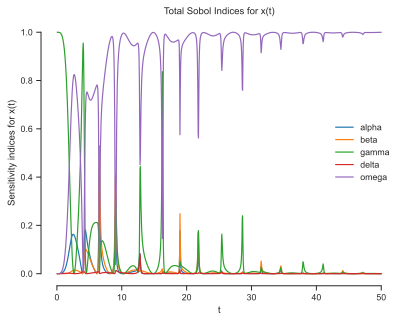

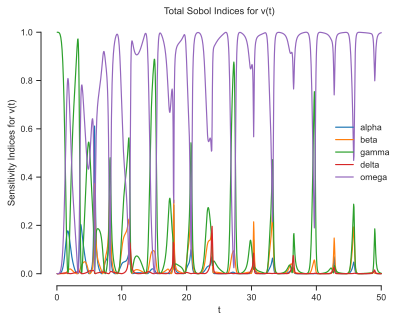

In [37]:
# We will have to recollect the samples for the total indices.
param_valuesT = sobol.sample(problem, N, calc_second_order=True)

# Rerun the model for new parameter sets
YT = vmap(run_model)(param_valuesT)

# Split into Results for each state
YT_x, YT_v = YT[:, :, 0], YT[:, :, 1]


# Redefine a function to get the second order at each time
def analyze_totalIndices(t):
    # Sobol analysis for x(t)
    Si_x = analyze_sobol.analyze(
        problem,
        YT_x[:, t],
        calc_second_order=True,
        print_to_console=False
    )
    # Sobol analysis for v(t)
    Si_v = analyze_sobol.analyze(
        problem,
        YT_v[:, t],
        calc_second_order=True,
        print_to_console=False
    )
    return (Si_x['ST'], Si_v['ST'])  # Return first-order indices for x and v

# Run the analysis for all timesteps (Cannot be vmapped because of the SALib API)
results_T = [analyze_totalIndices(t) for t in range(num_timesteps)]

# Unzip the results and split into x and v
ST_x, ST_v = zip(*results_T)
ST_x, ST_v = np.array(ST_x), np.array(ST_v)

# Plot with indices of x(t) with a for loop
fig, ax = plt.subplots()
for i, name in enumerate(problem['names']):
    ax.plot(times, ST_x[:, i], label=name)
ax.set(xlabel="t", ylabel="Sensitivity indices for x(t)")
ax.title.set_text("Total Sobol Indices for x(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

# Plot with indices of v(t) with a for loop
fig, ax = plt.subplots()
for i, name in enumerate(problem['names']):
    ax.plot(times, ST_v[:, i], label=name)
ax.set(xlabel="t", ylabel="Sensitivity Indices for v(t)")
ax.legend(frameon=False)
ax.title.set_text("Total Sobol Indices for v(t)")
sns.despine(trim=True);

Lets sum the total indices over time and plot them, we'll plot the first order ones as well for comparison.

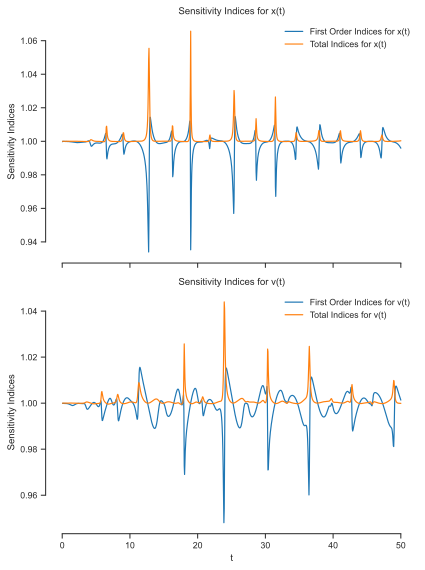

In [38]:
# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 8))

# Plot the indices for x(t) in the first subplot
ax1.plot(times, np.sum(S_x, axis=1), label="First Order Indices for x(t)")
ax1.plot(times, np.sum(ST_x, axis=1), label='Total Indices for x(t)')
ax1.set(ylabel="Sensitivity Indices")
ax1.legend(frameon=False)
ax1.title.set_text("Sensitivity Indices for x(t)")
sns.despine(ax=ax1, trim=True)

# Plot the indices for v(t) in the second subplot
ax2.plot(times, np.sum(S_v, axis=1), label="First Order Indices for v(t)")
ax2.plot(times, np.sum(ST_v, axis=1), label='Total Indices for v(t)')
ax2.set(xlabel="t", ylabel="Sensitivity Indices")
ax2.legend(frameon=False)
ax2.title.set_text("Sensitivity Indices for v(t)")
sns.despine(ax=ax2, trim=True)

# Adjust layout for better spacing
plt.tight_layout()

Here we see that the total indices rarely sum to less than one, this means that the first order indices do not account for all the variance in the output, and interactions between parameters are important in our dynamical system. Our total indices occasionally sum to more than one. This is fine in the case of total indices, as they are not constrained to sum to one. What is happening is that the interaction effections say the indices $S_{ij}$ and $S_{ji}$ are being double counted. So while first order indices are constrained to sum to one, total indices are not.

Feel free to play around with the number of samples and the number of time steps to see how the results change, try to drive the first order indices to never sum to more than one.